In [1]:
%load_ext autoreload
%autoreload 2

import os
import zarr
import dask.array as da
import napari
import sys
import numpy as np


from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

sys.path.append('..')
from tracks_interactions.db.db_model import Base, CellDB, TrackDB
import tracks_interactions.graph.family_graph as fg
#from tracks_interactions.widget.event_handler import EventHandler

In [2]:
from napari.settings import get_settings

settings = get_settings()
settings.application.playback_fps

5

In [2]:
os.environ['NAPARI_PERFMON'] = '0'

In [5]:
labels_zarr_path = r'D:\kasia\tracking\E6_exp\code\tests\example_track_labels.zarr'
labels = da.from_zarr(labels_zarr_path)
labels.shape
# from tifffile import imread
# labels = imread(r'D:\kasia\tracking\E6_exp\sample_data\track_labels.tif')

(241, 8396, 8401)

In [3]:
# get images
#ch1 = imread(r'D:\kasia\tracking\E6_exp\sample_data\ch1.tif')
#ch2 = imread(r'D:\kasia\tracking\E6_exp\sample_data\ch2.tif')
ch0_path = r'D:\kasia\tracking\zarr_tests\E6_C1_c1.zarr'
#r'D:\kasia\tracking\E6_exp\E6_C0.zarr'
ch1_path = r'D:\kasia\tracking\E6_exp\E6_C1.zarr'

ch0_da = da.from_zarr(ch0_path,1)
ch1_da = da.from_zarr(ch1_path,1)

In [4]:
from dask.distributed import Client

# Start a local Dask client
client = Client(n_workers=4, threads_per_worker=1)  # Adjust numbers based on your machine
print(client)

<Client: 'tcp://127.0.0.1:59634' processes=4 threads=4, memory=127.88 GiB>


In [14]:
zarr_array = zarr.open(ch0_path)
zarr_array[0].info

Name,/0
Type,zarr.core.Array
Data type,uint16
Shape,"(241, 16793, 16802)"
Chunk shape,"(50, 128, 128)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,135999185252 (126.7G)
No. bytes stored,400


In [5]:
ch0_list = []
for level in range(1,5):
    ch0_list.append(da.from_zarr(ch0_path,level))
    #ch0_list.append(zarr_array[level])

# ch1_list = []
# for level in range(1,5):
#     ch1_list.append(da.from_zarr(ch1_path,level))

In [5]:
# checkout labels as editable array
labels = np.array(labels).astype('int32')

In [6]:
# display channels and labels
viewer = napari.Viewer()
#labels_layer = viewer.add_labels(labels,name='Labels')
ch1 = viewer.add_image(ch0_da, name='ch1', colormap = 'green',blending='additive',contrast_limits=[0, 2048])
#ch2 = viewer.add_image(ch1_da, name='ch2', colormap = 'red',blending='additive')


In [7]:
scale = 2
ch1.data = ch0_list[scale - 1]
ch1.scale = [2**(scale-1),2**(scale-1)]
# ch2.data = ch1_list[scale - 1]
# ch2.scale = [2**(scale-1),2**(scale-1)]

In [7]:
# get access to the database
new_db_path = r'D:\kasia\tracking\E6_exp\sample_data\cells_database_expand.db'
#new_db_path =r'D:\kasia\tracking\E6_exp\sample_data\sample_db_2tables.db'
engine = create_engine(f'sqlite:///{new_db_path}')
session = sessionmaker(bind=engine)()

### Family graph display

In [8]:
from tracks_interactions.graph.family_graph import FamilyGraphWidget
plot_widget = FamilyGraphWidget(viewer,session)
viewer.window.add_dock_widget(plot_widget,area='bottom')

### Navigation widget

In [9]:
from tracks_interactions.widget.track_navigation_widget import TrackNavigationWidget
track_navigation_widget = TrackNavigationWidget(viewer,session)
viewer.window.add_dock_widget(track_navigation_widget,area='right',name='Track Navigation')

### Modification widget

In [10]:
from tracks_interactions.widget.track_modification_widget import TrackModificationWidget
track_modification_widget = TrackModificationWidget(viewer,session)
viewer.window.add_dock_widget(track_modification_widget,area='right',name='Track Modifications')

### Signal graph

In [11]:
from tracks_interactions.graph.signal_graph import SignalGraph
signal_list = ['ch0_nuc','ch0_cyto']
color_list = ['yellow','green']
graph_widget = SignalGraph(viewer,session,signal_list,color_list)
viewer.window.add_dock_widget(graph_widget,area='right',name='Cell Signals')

### Modify cell

In [12]:
from tracks_interactions.widget.cell_modification_widget import CellModificationWidget
cell_modification_widget = CellModificationWidget(viewer,session,ch_list=[ch0_da,ch1_da])
viewer.window.add_dock_widget(cell_modification_widget,area='right',name='Save Cell')

In [15]:
import ultrack
ultrack.__version__

'0.3.0'

### Tests

In [17]:
from tracks_interactions.graph.signal_graph import SignalGraphWidget
signal_widget = SignalGraphWidget(viewer,session)
viewer.window.add_dock_widget(signal_widget,area='right')

In [10]:
from numba import jit
from skimage.measure import regionprops, regionprops_table
import pandas as pd

In [21]:
%time
frame = 90
label_of_interest = 40
coords = np.argwhere(labels[frame] == label_of_interest)
ymin, xmin = coords.min(axis=0)
ymax, xmax = coords.max(axis=0)

SyntaxError: invalid syntax (2113402391.py, line 5)

In [19]:
# get coordinates of visible part
coord_view = viewer.layers['Labels'].corner_pixels.T
r_start = coord_view[1,0]
r_end = coord_view[1,1]
c_start = coord_view[2,0]
c_end = coord_view[2,1]

labels_cropped = labels[frame, r_start:r_end, c_start:c_end]==label_of_interest

In [20]:
labels_cropped.shape

(403, 315)

In [15]:
t = viewer.layers['Labels'].data
sel = t[tuple(slice(i[0], i[1]) for i in layer.corner_pixels.T)]

NameError: name 'layer' is not defined

In [20]:
%time
data = regionprops_table([labels[9]==40],properties=['label','centroid','area','bbox'])

CPU times: total: 0 ns
Wall time: 0 ns


AttributeError: 'list' object has no attribute 'ndim'

In [10]:
tr = session.query(TrackDB).filter_by(track_id=12539).first()
print(tr.t_begin,tr.t_end,tr.parent_track_id,tr.root)

AttributeError: 'NoneType' object has no attribute 't_begin'

In [16]:
from sqlalchemy import and_
from tracks_interactions.db.db_model import CellDB
import matplotlib.pyplot as plt

In [23]:
curr_tr = 14711
curr_fr = 130
c = session.query(CellDB).filter(and_(CellDB.track_id == curr_tr, CellDB.t == curr_fr)).first()
    

In [19]:
%time
c = session.query(CellDB).filter(and_(CellDB.track_id == curr_tr, CellDB.t == curr_fr)).first()

CPU times: total: 0 ns
Wall time: 0 ns


In [24]:
%time
all_cells = session.query(CellDB).filter(CellDB.track_id == curr_tr).all()

CPU times: total: 0 ns
Wall time: 0 ns


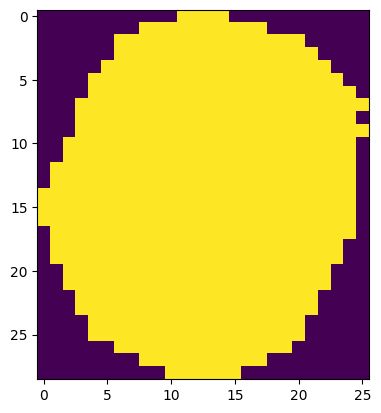

In [22]:
plt.imshow(c.mask)